In [168]:
# Import libraries
import pandas as pd
import numpy as np
import re
import os 
import datetime as dt
from collections import Counter

# Import viz
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False)

# Pandas display options
pd.options.display.max_columns = 50
pd.options.display.max_rows = 25
pd.options.display.max_colwidth = 50
pd.set_option.precision = 3

### Load the article data

In [10]:
# Load articles w/ comments
print(os.listdir('../data/cleaned/'))
articles = pd.read_csv('../data/cleaned/articles.csv', header=0, parse_dates=['scrape_datetime','post_datetime'])
articles.shape

['articles.csv', 'comments.csv']


(202862, 8)

In [11]:
# Inspect the head of the data
articles.head()

article_title  \
0                              Week 7 2020 best bets   
1  Antonio Brown’s civil sexual assault trial cur...   
2  Derrick Henry: MVP conversation needs to start...   
3  Mekhi Becton set to join Sam Darnold in return...   
4         Raiders, Saints have no new positive tests   

                                         article_url  \
0  https://profootballtalk.nbcsports.com/2020/10/...   
1  https://profootballtalk.nbcsports.com/2020/10/...   
2  https://profootballtalk.nbcsports.com/2020/10/...   
3  https://profootballtalk.nbcsports.com/2020/10/...   
4  https://profootballtalk.nbcsports.com/2020/10/...   

                                        article_body  \
0  \n\n\n \n\n\n Getty Images\n\nWeek Seven of th...   
1  \n\n\n \n\n\n Getty Images\n\nWhen the NFL sus...   
2  \n\n\n \n\n\n Getty Images\n\nTitans running b...   
3  \n\n\n \n\n\n Getty Images\n\nThe Jets should ...   
4  \n\n\n \n\n\n Getty Images\n\nIt’s game on tod...   

             scrape_datetime  \
0 2020-10-25 10:53:51.516183   
1 2020-10-25 10:53:51.516183   
2 2020-10-25 10:53:51.516183   
3 2020-10-25 10:53:51.516183   
4 2020-10-25 10:53:51.516183   

                                            page_url       post_datetime  \
0  https://profootballtalk.nbcsports.com/category... 2020-10-25 10:32:00   
1  https://profootballtalk.nbcsports.com/category... 2020-10-25 10:12:00   
2  https://profootballtalk.nbcsports.com/category... 2020-10-25 09:36:00   
3  https://profootballtalk.nbcsports.com/category... 2020-10-25 08:05:00   
4  https://profootballtalk.nbcsports.com/category... 2020-10-25 08:05:00   

                author  comment_counts  
0          Mike Florio             0.0  
1          Mike Florio             1.0  
2          Mike Florio            10.0  
3           Josh Alper             4.0  
4  Michael David Smith             5.0

### When were articles published?
It seems like there is an overall trend upward over time along with a fairly clear cyclical pattern starting in 2013 which looks like articles posted "in season"

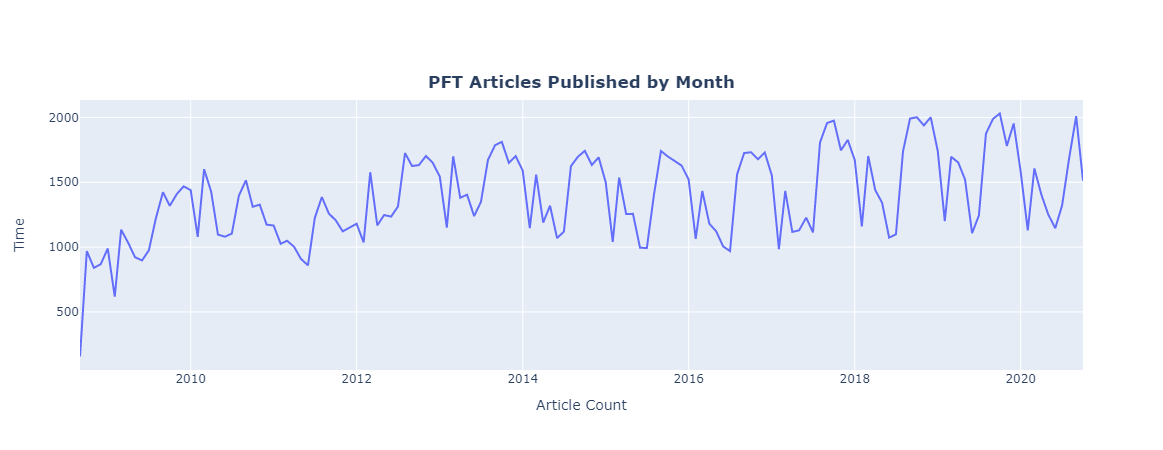

In [84]:
# Summarize articles published by month
data = pd.DataFrame(articles['post_datetime'].groupby(articles.post_datetime.dt.to_period("M")).agg('count')).rename(columns={'post_datetime':'count'}).reset_index()
data['post_datetime'] = data['post_datetime'].astype(str)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data['post_datetime'],
    y=data['count'],
    name=''
))

fig.update_layout(
    title={
        'text': "<b>PFT Articles Published by Month</b>",
        'y':0.83,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Article Count",
    yaxis_title="Time",
)

fig.write_html('../plots/pft_articles_published_by_month.html')
fig.show()

### Who has published the most articles?
Florio takes the cake with >25%; the top 4 represent ~74% of all articles

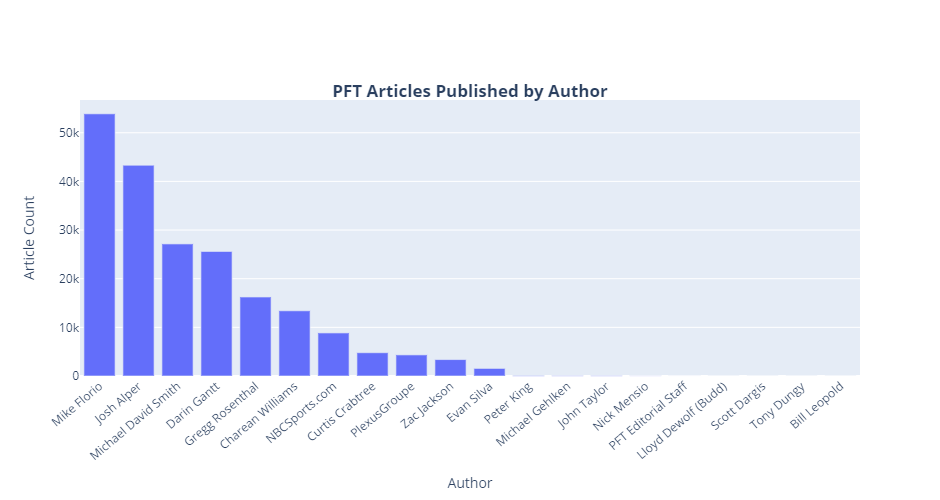

In [116]:
data = pd.DataFrame(articles['author'].groupby(articles.author).agg('count')).rename(columns={'author':'count'}).reset_index()
data['percentage'] = (data['count']  / data['count'].sum()) * 100
data = data.round(2)
data['hovertext'] = data['percentage'].astype(str) + '% of total'
data = data.sort_values(by=['count'], ascending=False)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['author'],
    y=data['count'],
    hovertext=data['hovertext']
))
                      
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    title={
        'text': "<b>PFT Articles Published by Author</b>",
        'y':0.83,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Author",
    yaxis_title="Article Count",
)
fig.update_xaxes(tickangle=320)

fig.write_html('../plots/pft_articles_published_by_author.html')
fig.show()

### Have authors been consistently publishing articles?

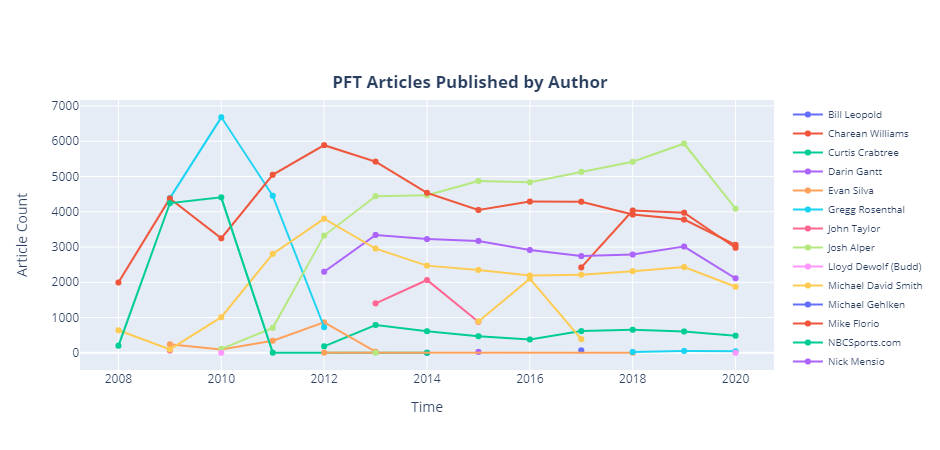

In [141]:
data = pd.DataFrame(articles['post_datetime'].groupby([articles.author, articles.post_datetime.dt.to_period("y")]).agg('count')).rename(columns={'post_datetime':'count'}).reset_index()
data['post_datetime'] = data['post_datetime'].astype(str)

fig = go.Figure()
for a in data.author.unique():
    fig.add_trace(go.Scatter(
        x=data[data.author == a]['post_datetime'],
        y=data[data.author == a]['count'],
        name=a,
        connectgaps=False
    ))
                      
fig.update_layout(
    autosize=True,
    #width=600,
    #height=500,
    title={
        'text': "<b>PFT Articles Published by Author</b>",
        'y':0.83,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Time",
    yaxis_title="Article Count",
    legend = dict(
        font = dict(
            size = 10
        ))
)

# fig.write_html('../plots/pft_articles_published_by_author_by_month.html')
fig.write_html('../plots/pft_articles_published_by_author_by_year.html')
fig.show()

### What days of the week are articles published on?

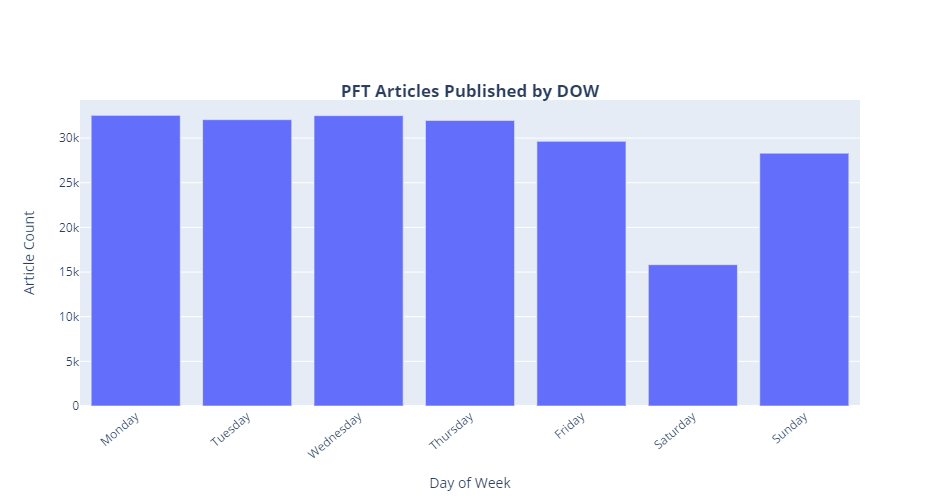

In [213]:
data = pd.DataFrame(articles['post_datetime'].groupby([articles.post_datetime.dt.day_name().rename('dayofweek'), articles.post_datetime.dt.weekday.rename('weekday')]).agg('count')).reset_index()
data = data.sort_values(by=['weekday'])

fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['dayofweek'],
    y=data['post_datetime']
))
                      
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    title={
        'text': "<b>PFT Articles Published by DOW</b>",
        'y':0.83,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Day of Week",
    yaxis_title="Article Count",
)
fig.update_xaxes(tickangle=320)

fig.write_html('../plots/pft_articles_published_by_dow.html')
fig.show()

### What hour of the day are articles published?

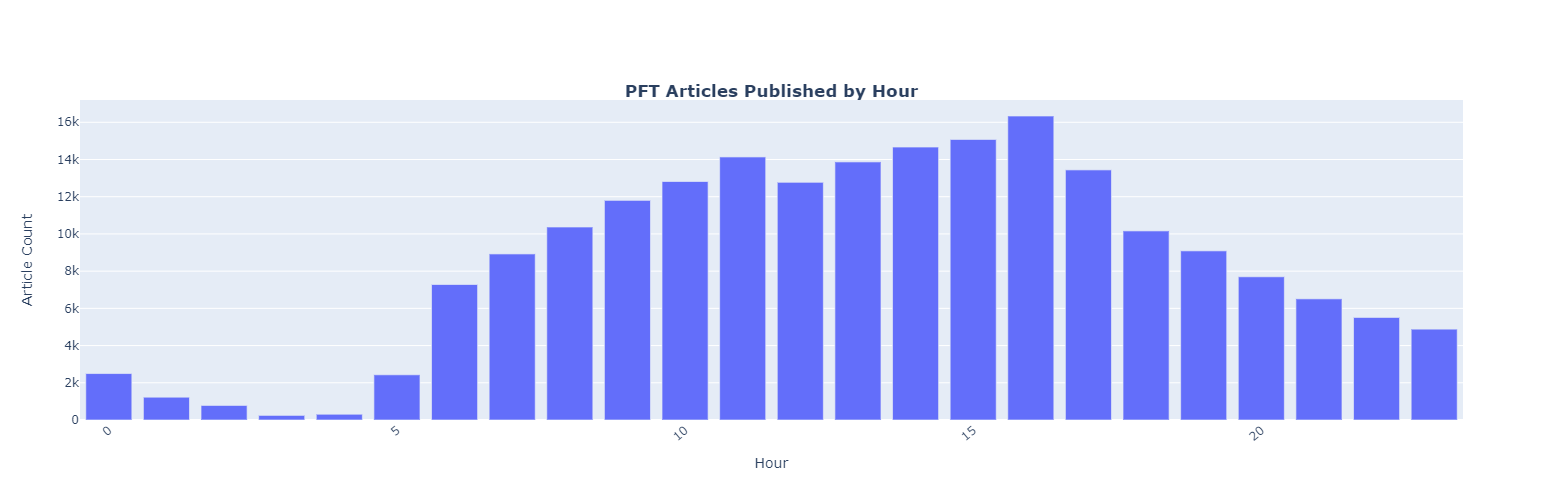

In [216]:
data = pd.DataFrame(articles['post_datetime'].groupby([articles.post_datetime.dt.hour.rename('hour')]).agg('count')).reset_index()
data = data.sort_values(by=['hour'])

fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['hour'],
    y=data['post_datetime']
))
                      
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    title={
        'text': "<b>PFT Articles Published by Hour</b>",
        'y':0.83,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Hour",
    yaxis_title="Article Count",
)
fig.update_xaxes(tickangle=320)

fig.write_html('../plots/pft_articles_published_by_hour.html')
fig.show()

### Are there really common phrases in article titles?

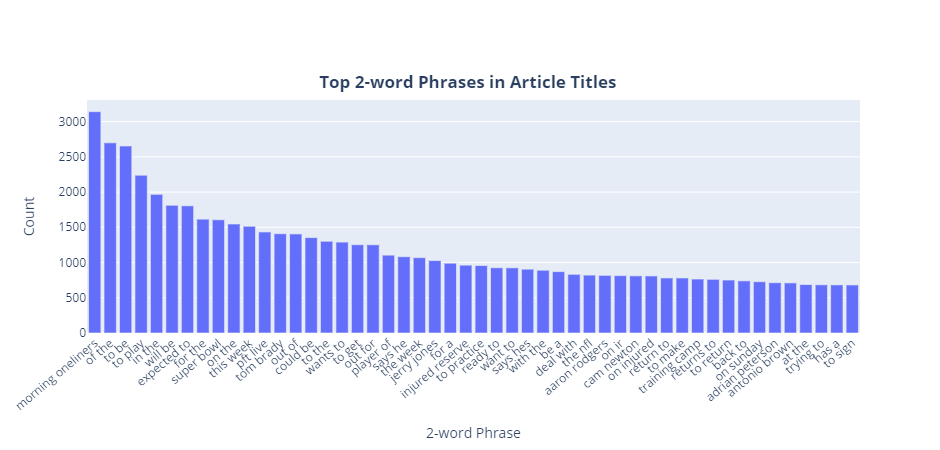

In [177]:
bigrams = dict()
for t in articles.article_title:
    t = t.lower()
    t = re.sub(r'[^A-Za-z0-9 ]+', '', t)
    t = t.split()
    if len(t) < 2:
        continue
    for i in range(len(t)-1):
        phrase = ' '.join(t[i:i+2])
        if phrase in bigrams.keys():
            bigrams[phrase] += 1
        else:
            bigrams[phrase] = 1
            
data = Counter(bigrams)
data = pd.DataFrame(data.most_common(50), columns=['phrase','count'])

fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['phrase'],
    y=data['count']
))
                      
fig.update_layout(
    autosize=True,
    #width=600,
    #height=500,
    title={
        'text': "<b>Top 2-word Phrases in Article Titles </b>",
        'y':0.83,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="2-word Phrase",
    yaxis_title="Count",
)
fig.update_xaxes(tickangle=320)

fig.write_html('../plots/top_50_two_word_phrases_in_article_titles.html')
fig.show()

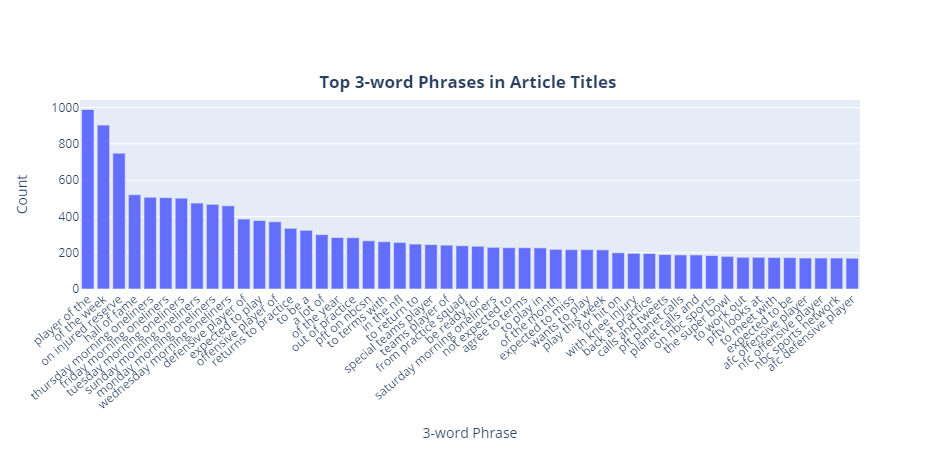

In [217]:
trigrams = dict()
for t in articles.article_title:
    t = t.lower()
    t = re.sub(r'[^A-Za-z0-9 ]+', '', t)
    t = t.split()
    if len(t) < 3:
        continue
    for i in range(len(t)-2):
        phrase = ' '.join(t[i:i+3])
        if phrase in trigrams.keys():
            trigrams[phrase] += 1
        else:
            trigrams[phrase] = 1
            
data = Counter(trigrams)
data = pd.DataFrame(data.most_common(50), columns=['phrase','count'])

fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['phrase'],
    y=data['count']
))
                      
fig.update_layout(
    autosize=True,
    #width=600,
    #height=500,
    title={
        'text': "<b>Top 3-word Phrases in Article Titles </b>",
        'y':0.83,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="3-word Phrase",
    yaxis_title="Count",
)
fig.update_xaxes(tickangle=320)

fig.write_html('../plots/top_50_three_word_phrases_in_article_titles.html')
fig.show()

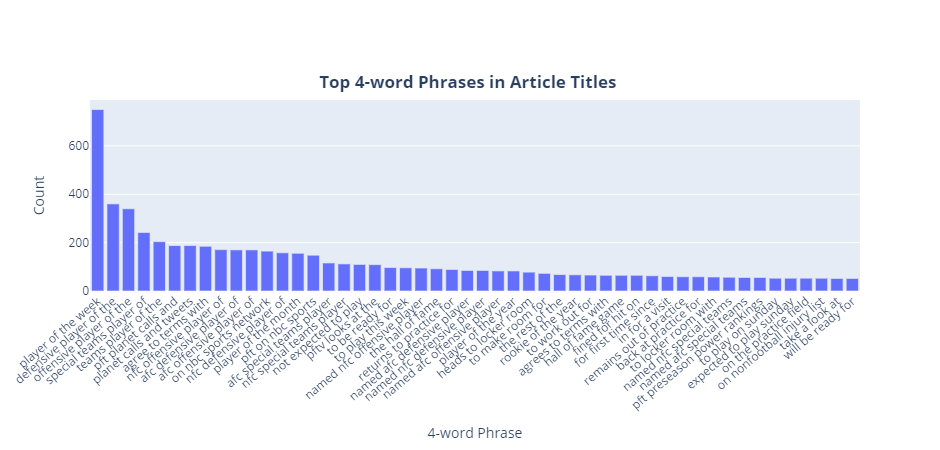

In [191]:
trigrams = dict()
for t in articles.article_title:
    t = t.lower()
    t = re.sub(r'[^A-Za-z0-9 ]+', '', t)
    t = t.split()
    if len(t) < 4:
        continue
    for i in range(len(t)-3):
        phrase = ' '.join(t[i:i+4])
        if phrase in trigrams.keys():
            trigrams[phrase] += 1
        else:
            trigrams[phrase] = 1
            
data = Counter(trigrams)
data = pd.DataFrame(data.most_common(50), columns=['phrase','count'])

fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['phrase'],
    y=data['count']
))
                      
fig.update_layout(
    autosize=True,
    #width=600,
    #height=500,
    title={
        'text': "<b>Top 4-word Phrases in Article Titles </b>",
        'y':0.83,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="4-word Phrase",
    yaxis_title="Count",
)
fig.update_xaxes(tickangle=320)

fig.write_html('../plots/top_50_four_word_phrases_in_article_titles.html')
fig.show()

### How many comments have PFT articles received over time?

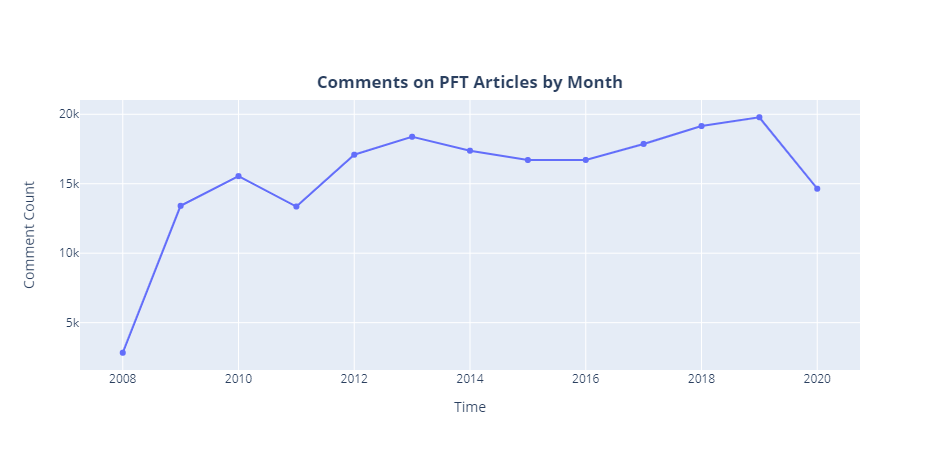

In [248]:
# Summarize comments by month
data = pd.DataFrame(articles[['post_datetime','comment_counts']].groupby([articles.post_datetime.dt.to_period("Y")])['comment_counts'].agg(['count','sum'])).reset_index()
data['normalized'] = data['sum'] / data['count']
data['post_datetime'] = data['post_datetime'].astype(str)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data['post_datetime'],
    y=data['count'],
    name=''
))

fig.update_layout(
    title={
        'text': "<b>Comments on PFT Articles by Month</b>",
        'y':0.83,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Time",
    yaxis_title="Comment Count",
)

# fig.write_html('../plots/comments_on_pft_articles_by_month.html')
fig.show()

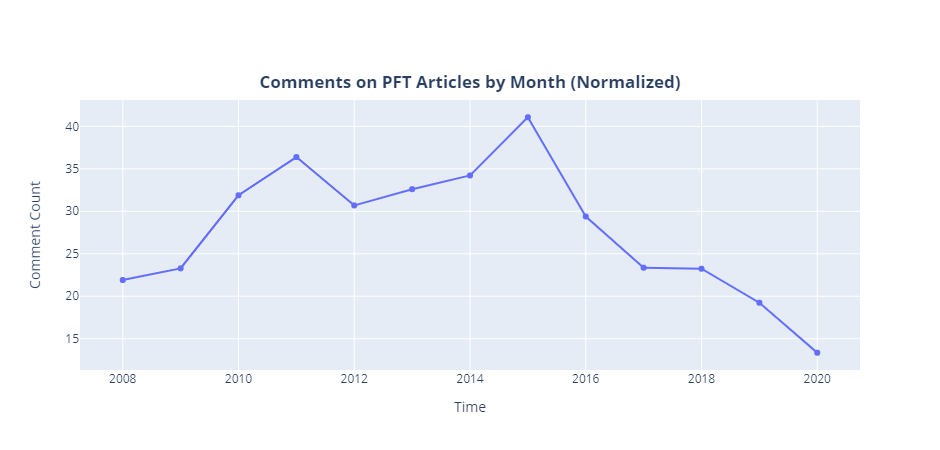

In [249]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data['post_datetime'],
    y=data['normalized'],
    name=''
))

fig.update_layout(
    title={
        'text': "<b>Comments on PFT Articles by Month (Normalized)</b>",
        'y':0.83,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Time",
    yaxis_title="Comment Count",
)

# fig.write_html('../plots/comments_on_pft_articles_by_month_normalized.html')
fig.show()

### Which authors articles have received the most comments?

In [242]:
data = pd.DataFrame(articles[['post_datetime','comment_counts']].groupby([articles.author, articles.post_datetime.dt.to_period("y")])['comment_counts'].agg(['count','sum'])).reset_index()
data['normalized'] = data['sum'] / data['count']
data['post_datetime'] = data['post_datetime'].astype(str)
data

author post_datetime  count      sum  normalized
0       Bill Leopold          2014      1      6.0    6.000000
1   Charean Williams          2017   2421  29363.0   12.128459
2   Charean Williams          2018   4036  62742.0   15.545590
3   Charean Williams          2019   3972  53086.0   13.365055
4   Charean Williams          2020   2979  28186.0    9.461564
..               ...           ...    ...      ...         ...
86      Scott Dargis          2013      1      5.0    5.000000
87        Tony Dungy          2020      1     24.0   24.000000
88       Zac Jackson          2015    889  20182.0   22.701912
89       Zac Jackson          2016   2102  42083.0   20.020457
90       Zac Jackson          2017    388   8360.0   21.546392

[91 rows x 5 columns]